# Generative adversarial networks

Generative adversarial networks are a powerful model for modeling the distribution of a desired dataset. It is by name a generative model, meaning it learns parameters that can recreate the distribution of the training dataset. It's composed of two networks - the generator and discriminator - with opposing objectives. It is this opposition that allows GANs to perform so well in generating natural images, even faces. Alongside with VAEs, GANs are one of the most widely used generative deep learning models.

The generator network takes noise as a input - usually Gaussian noise - and attempts to recreate an image close enough to the training data that it fools the discriminator. Thus, it's goal is to fool the discriminator into classifying its image as 1 - a real image from the real data distribution. On the other hand, the discriminator is attempting to achieve the opposite - it wants to learn how to classify the real images as 1 and the generator's image as 0. This battle is captured by the GAN loss function:

![](loss.png)

The first term of the loss function is what the discriminator classifies a real input as. Since we want it to output a probability close to 1, we want the parameters of D to maximize this term. Recall that the log function is a monotonically increasing function, so maximizing this term will push D to output probabilities closer to 1 for a real image. The second term is what the discriminator classifies a generated input as. Since we want it to output a probability close to 0 in this case, we want the inside of the log function to be as close to one as possible, hence we also maximize this term.

Now, the generator wants the opposite. G wants D to output 1 with its generated input, pushing the inside of the second log term towards 0. Thus it wants to learn parameters that minimize this term. Since G does not impact the first term, we can wrap this whole expression with the minmax.

This seems straightforward once you understand it, but in practice training GANs are pretty hard. Primarily because improving one of the networks comes at the expense of the other. It is difficult to know when GANs have "converged";  the loss does not directly indicates this. The equilibrium that is desired may be fleeting and not a stable point that is reached. Additionally, there are many failure modes when training that may occur if hyperparameters or network configurations are not set up correctly. In fact, if the training does converge, then probably the discriminator or the generator has completely failed and the other network has "won". What we want is an equilibrium (specifically a Nash equilibrium, a term from game theory that means that any opponent's action does not change the outcome, or the solution to a minimax game). Another failure mode is mode collapse, where the generator relies on very few select outputs to fool the discirminator.

Because of these challenges, there are a plethora of practical tips for taming the black magic that is GANs. These are some tips gathered from various sources:

- Model weights should be randomly initialized from a normal distribution with mean 0, STD 0.02
- Use strided convolutions for downsampling and not pooling layers so the network can learn its own spatial downsampling
- Batch normalization layers in between convolutional layers (even transposed convolutions) in discriminator and generator to help with gradient flow, which is critical to prevent the generator from collapsing all samples toa. single point (mode collapse)
- Use ReLU activations in generator with TanH function at the last output layer. Some even use LEaky ReLU
- Use Leaky ReLU in the discriminator to promote gradient flow (slope = 0.2), sigmoid in the last output layer (for outputting probability)
- Remove fully connected hidden layers
- Use Adam optimizers with learning rate 0.0002 and Beta1 = 0.5
- Construct different mini-batches for real and fake imaages, i.e., don't mix real and fake images in the same minibatch when training
- Adjust G's objective function to maximize $logD(G(z))$ for better gradients instead of $log(1-D(G(z)))$ (BCEloss in PyTorch is the negative version of this, so the optimizer step will minimize BCEloss which in turn maximizes the desired objective function) and use true labels when training generator and showing generator's output to discriminator 
- Update D and G independently, i.e., show D a real example, store gradients, show D a fake example, store gradients, update D, generate an example and show D and calculate G's loss, update G. Some people add the two gradient updates for D, some average them
- Save models after every interval of iterations/epoch and save the generated image. The best model may be in the middle of training
- Normalize the images between -1 and 1, hence the Tanh output activation
- Sample latent variables from a normal distribution
- For upsampling, use strided transposed convolutions and Pixel Shuffle at the last layer (Shi et al. 2016)
- Use fuzzy labels, i.e., replace true label with random number between 0.7 and 1.2, fake with random number between 0.0 and 0.3. This idea is from Salimans et al. 2016, but they only use label smoothing for the positive labels. This is thought to improve network robustness to adversarial examples. Tricks that cripple the discriminator are thought to work well because early in training the generator distribution is far from the real data distribution, and the discriminator has an easy time distinguishing the two and may overfit.
- Use the DCGAN architecture if you can (Radford et al. 2016) or a hybrid model (KL + GAN, VAE + GAN)
- DCGAN paper uses batch size of 128 with Adam SGD
- Use labels if you have them, almost always results in a dramatic improvement in quality
- Add noise to the inputs of D and decay noise over time
- Use dropout of 50 percent in the generator (not sure how I feel about this)

For more reading, see:

[1] https://machinelearningmastery.com/faq/single-faq/why-is-my-gan-not-converging/

[2] https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/

[3] https://machinelearningmastery.com/how-to-code-the-generative-adversarial-network-training-algorithm-and-loss-functions/

[4] https://github.com/soumith/ganhacks

[5] https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

[6] DCGAN paper: https://arxiv.org/abs/1511.06434 

[7] NIPS 2016 tutorial on GANs: https://arxiv.org/abs/1701.00160

[8] On adding noise to the discriminator: https://www.inference.vc/instance-noise-a-trick-for-stabilising-gan-training/

Here, we will construct a basic DCGAN for _generation of faces_ in PyTorch. We will implement some of the tips mentioned above, and see how to assess the model's performance. This follows the PyTorch DCGAN tutorial very closely.

### Parameters

In [1]:
# Root directory for dataset
dataroot = 'celeba'
# Number of workers for dataloader
workers = 2
# Batch size during training
batch_size = 128
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of training epochs
num_epochs = 5
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

### Dataset

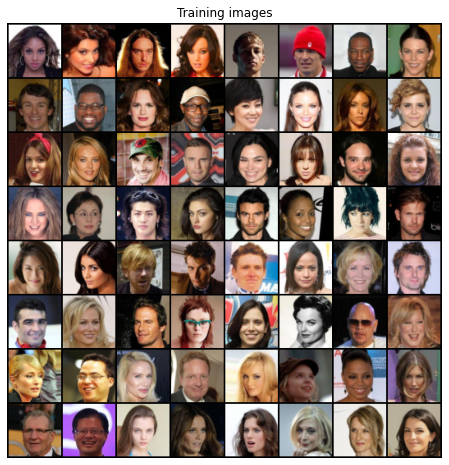

In [2]:
import torch
import torch.nn as nn
from torch.utils import data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import numpy as np

# Create the dataset using the ImageFolder class
# We also preprocess by resizing, center cropping, cast to Tensor (which auto maps range to [0,1]), then
# change the range with normalize (subtracts 0.5 from mean in each dimension, divides by 0.5) to
# [-1, 1]
dataset = dset.ImageFolder(root = dataroot,
                           transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                           ]))

dataloader = data.DataLoader(dataset, 
                             batch_size = batch_size,
                             shuffle = True,
                             num_workers = workers
                            )

device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')

test_batch = next(iter(dataloader))[0].to(device)
plt.figure(figsize = (8,8))
plt.axis('off')
plt.title('Training images')
plt.imshow(np.transpose(vutils.make_grid(test_batch[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Weight initialization

We want our weights to be randomly initialized from a normal distribution with mean 0, STD 0.02. We use a custom weights initialization function which should take a model and change their weights.

In [3]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

Now we will create our generator class. Here, I will slightly diverge from the PyTorch tutorial. I'll still follow the general advice listed by the DCGAN paper, but with a custom architecture. I will use a VAE as the generator instead. Yes, this goes against the tip of not using fully connected layers... but for VAEs this is more commonplace. Also, batchnorm is typically avoided in VAEs as it may interfere with the latent space, but it has been successfully implemented with a GAN in Larsen et al. 2016. I will follow a similar setup to theirs.

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_shape, latent_dim, num_filters):
        super().__init__()
        self.convnet = nn.Sequential(
                nn.Conv2d(input_shape[0], num_filters, kernel_size = 4, stride = 2, padding = 1),
                nn.BatchNorm2d(num_filters),
                nn.ReLU(),
                nn.Conv2d(num_filters, num_filters * 2, kernel_size = 4, stride = 2, padding = 1),
                nn.BatchNorm2d(num_filters * 2),
                nn.ReLU(),
                nn.Conv2d(num_filters * 2, 1, kernel_size = 1, stride = 1, padding = 0),
                nn.BatchNorm2d(1),
                nn.ReLU()
                )
        
        flattened_size = int(input_shape[1] / 4 * input_shape[2] / 4)

        self.fc_mu = nn.Sequential(
            nn.Linear(flattened_size, latent_dim),
            nn.ReLU()
        )
        
        self.fc_logvar = nn.Sequential(
            nn.Linear(flattened_size, latent_dim),
            nn.ReLU()
        )
        
    def forward(self, x):
        h = self.convnet(x)
        batch_size = h.shape[0]
        h = h.view(batch_size, -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        
        return mu, logvar
    

class Decoder(nn.Module):
    def __init__(self, input_shape, latent_dim, num_filters):
        super().__init__()
        flattened_size = int(input_shape[1] / 4 * input_shape[2] / 4)
        self.reshape = (input_shape[1] // 4, input_shape[2] // 4)

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, flattened_size),
            nn.BatchNorm1d(flattened_size),
            nn.ReLU()
        )
        
        self.convnet = nn.Sequential(
            nn.ConvTranspose2d(1, num_filters * 2, kernel_size = 1, stride = 1, padding = 0),
            nn.BatchNorm2d(num_filters * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(num_filters * 2, num_filters, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Conv2d(num_filters, input_shape[0] * 2 ** 2, kernel_size = 3, stride = 1, padding = 1),
            nn.PixelShuffle(2),
            nn.Tanh()
        )
        
    def forward(self, x):
        h = self.fc(x)
        batch_size = h.shape[0]
        h = h.view(batch_size, -1, self.reshape[0], self.reshape[1])
        recon = self.convnet(h)
        
        return recon
        

class VAE(nn.Module):
    """
    Full VAE architecture with encoder, latent sampling, and decoder
    """
    def __init__(self, input_shape, latent_dim, num_filters):
        super().__init__()

        self.encoder = Encoder(input_shape, latent_dim, num_filters)
        self.decoder = Decoder(input_shape, latent_dim, num_filters)

    def forward(self, x):
        # First pass through encoder
        mu, logvar = self.encoder(x)

        # Sample from latent distribution using reparametrization
        std = torch.exp(logvar / 2)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mu)

        # Pass through decoder
        x_recon = self.decoder(z)

        return x_recon, mu, logvar

In [6]:
input_shape = (nc, image_size, image_size)

G = VAE(input_shape, nz, ngf)

G.apply(weights_init)

print(G)

VAE(
  (encoder): Encoder(
    (convnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
      (7): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
    )
    (fc_mu): Sequential(
      (0): Linear(in_features=256, out_features=100, bias=True)
      (1): ReLU()
    )
    (fc_logvar): Sequential(
      (0): Linear(in_features=256, out_features=100, bias=True)
      (1): ReLU()
    )
  )
  (decoder): Decoder(
    (fc): Sequential(
      (0): Linear(in_features=100, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, aff

### Discriminator

There are some options we could try here for patch-based classification. We could use the PatchGAN discriminator from Isola et al. 2017, implemented as described in https://machinelearningmastery.com/how-to-implement-pix2pix-gan-models-from-scratch-with-keras/. A potential concern is that the objective of this architecture was image-to-image translation, which is not our intended goal.

Another option is the discriminator architecture specified by Sabokrou et al 2019. This was applied for visual irregularity detection in videos and relies on 1x1 convolutional layers in between normal convolutional layers to "enrich" the spatial features.

We will make something similar to both...

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_shape, num_filters):
        super().__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(input_shape[0], num_filters, kernel_size = 4, stride = 2, padding = 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(num_filters, num_filters * 2, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm2d(num_filters * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(num_filters * 2, num_filters * 4, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm2d(num_filters * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(num_filters * 4, num_filters * 8, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm2d(num_filters * 8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(num_filters * 8, 1, kernel_size = 1, stride = 1, padding = 0),
            nn.Sigmoid()
        )
        
        
    def forward(self, x):
        return self.convnet(x)

In [8]:
input_shape = (nc, image_size, image_size)
patch_size = int(64 / 2 ** 4)

D = Discriminator(input_shape, ndf)

D.apply(weights_init)

print(D)

Discriminator(
  (convnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
    (12): Sigmoid()
  )
)


### Loss function and optimizers

We have two loss functions - the loss for the latent space and the reconstruction loss. Typically for VAEs this is L1 or L2 loss of the generated image with the original image plus KL divergence from normal distribution for the latent space loss. In this case, we will add a discriminator loss component in the form of binary cross entropy. In the pix2pix/patchGAN paper, they used L1 loss with discriminator loss and weighted L1 via $\lambda$ = 100 for the generator objective function. The discriminator objective function remains only BCE.

In [9]:
import torch.optim as optim

def discriminator_loss(y_pred, y_real):
    loss = nn.BCELoss(reduction = 'sum')
    return loss(y_pred, y_real)

def generator_loss(x_orig, x_recon, mu, logvar, y_pred, y_real, loss_weights = (1, 1, 1)):
    """
    Objective function for the generator: KL divergence, L1 loss, and discriminator loss
    loss weights are in that order
    """
    recon_loss = nn.L1Loss(reduction = 'sum')
    MAE = recon_loss(x_recon, x_orig)
    
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    
    BCE = discriminator_loss(y_pred, y_real)
    
    triple_loss = loss_weights[0] * MAE + loss_weights[1] * KLD + loss_weights[2] * BCE
    
    return triple_loss, MAE, KLD, BCE


real_label = 1
fake_label = 0
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

### Training

In [10]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 10

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        D.zero_grad()
        # Format batch
        batch_real = data[0].to(device)
        batch_size = batch_real.size(0)
        label = torch.full((batch_size,1,patch_size,patch_size), real_label, device=device)
        # Forward pass real batch through D
        pred = D(batch_real)
        # Calculate loss on all-real batch
        errD_real = discriminator_loss(pred, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = pred.mean().item()

        ## Train with all-fake batch
        # Generate fake image batch with G
        fake, mu, logvar = G(batch_real)
        label.fill_(fake_label)
        # Classify all fake batch with D
        pred = D(fake.detach())
        # Calculate D's loss on the all-fake batch
        errD_fake = discriminator_loss(pred, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = pred.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = (errD_real + errD_fake) / 2
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        pred = D(fake)
        # Calculate G's loss based on this pred
        errG, mae, kld, bce = generator_loss(batch_real, fake, mu, logvar, pred, label, loss_weights = (0.01, 1 ,1))
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = pred.mean().item()
        # Update G
        optimizerG.step()

        # pred training stats
        if i % 1 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f (\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            print('MAE: %.4f\tKLD: %.4f\tBCE: %.4f' % (mae, kld, bce))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's pred on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake, _, _ = G(test_batch)
            img_list.append(vutils.make_grid(fake.detach().cpu(), padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/10][0/1583]	Loss_D: 1455.4854	Loss_G: 856479.6250 (	D(x): 0.4493	D(G(z)): 0.4490 / 0.4549
MAE: 853872.9375	KLD: 950.2030	BCE: 1656.5189
[0/10][1/1583]	Loss_D: 1530.8267	Loss_G: 822033.8750 (	D(x): 0.4619	D(G(z)): 0.4575 / 0.4609
MAE: 819463.9375	KLD: 966.6676	BCE: 1603.2529
[0/10][2/1583]	Loss_D: 1433.7830	Loss_G: 808170.0625 (	D(x): 0.4666	D(G(z)): 0.4618 / 0.4661
MAE: 805540.3750	KLD: 1038.8018	BCE: 1590.9005
[0/10][3/1583]	Loss_D: 1435.5715	Loss_G: 817414.5625 (	D(x): 0.4749	D(G(z)): 0.4678 / 0.4706
MAE: 814849.3125	KLD: 1009.1778	BCE: 1556.0652
[0/10][4/1583]	Loss_D: 1411.0374	Loss_G: 781568.9375 (	D(x): 0.4825	D(G(z)): 0.4719 / 0.4744
MAE: 779008.3750	KLD: 1018.2517	BCE: 1542.3330
[0/10][5/1583]	Loss_D: 1407.4274	Loss_G: 794457.8750 (	D(x): 0.4894	D(G(z)): 0.4759 / 0.4774
MAE: 791618.8125	KLD: 1313.4556	BCE: 1525.6245
[0/10][6/1583]	Loss_D: 1392.0601	Loss_G: 776387.3750 (	D(x): 0.4973	D(G(z)): 0.4788 / 0.4788
MAE: 773432.1250	KLD: 1436.4362	BCE: 1518.8

Traceback (most recent call last):
  File "/Users/rafi/opt/anaconda3/envs/py37/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/rafi/opt/anaconda3/envs/py37/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/rafi/opt/anaconda3/envs/py37/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/rafi/opt/anaconda3/envs/py37/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 